In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score,precision_score,recall_score
import random


torch.backends.cudnn.deterministic = True
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
np.random.seed(123)
random.seed(123)
torch.cuda.manual_seed_all(123)

tokenizer = AutoTokenizer.from_pretrained("joeddav/xlm-roberta-large-xnli")

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("../data/constraint_hindi_train.csv")
taglist = list()
for i in range(len(df)):
    tags = df.iloc[i]["Labels Set"].split(",")
    for tag in tags:
        if(tag not in taglist):
            taglist.append(tag)

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, datapath):
        
        self.df = pd.read_csv(datapath)
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        sentence = self.df.iloc[idx]["Post"]
        encoding = tokenizer.encode(sentence,add_special_tokens=True,max_length=64,truncation=True,pad_to_max_length=True,return_attention_mask=True)
        input_ids = encoding
        labels = np.zeros(5)
        tags = self.df.iloc[idx]["Labels Set"].split(",")
        for tag in tags:
            labels[taglist.index(tag)] = 1
        return np.array(input_ids), labels
# trainset = Dataset("../train_new.csv")
trainset = Dataset("../data/constraint_hindi_train.csv")
valset = Dataset("../data/constraint_hindi_valid.csv")


trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size = 1, shuffle=False)

In [3]:
# class bert_model(nn.Module):  ## all tokens
#     def __init__(self):
#         super(bert_model, self).__init__()
#         self.bert = AutoModelForSequenceClassification.from_pretrained("joeddav/xlm-roberta-large-xnli")
#         self.bert = torch.nn.Sequential(*(list(self.bert.children())[:-1])) ## deleting the last classification layer
#         self.linear1 = nn.Linear(in_features=1024, out_features=5)
#         self.sigmoid = nn.Sigmoid()
#     def forward(self,sent):
#         x = model.bert[0].embeddings(sent.to("cuda:0"))
#         for i in range(len(model.bert[0].encoder.layer)):
#             device = torch.device("cuda:"+str(i%4))
#             x = model.bert[0].encoder.layer[i](x.to(device))[0]
#         seq = torch.mean(x, dim = 1).squeeze()
        
#         seq = self.linear1(seq.to("cuda:0"))
# #         seq = self.linear2(seq.to("cuda:0"))
#         seq = self.sigmoid(seq)
#         return seq

## CLS token only
class bert_model(nn.Module): 
    def __init__(self):
        super(bert_model, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained("joeddav/xlm-roberta-large-xnli")
        self.bert = torch.nn.Sequential(*(list(self.bert.children())[:-1])) ## deleting the last classification layer
        self.linear1 = nn.Linear(in_features=1024, out_features=5)
        self.sigmoid = nn.Sigmoid()
    def forward(self,sent):
        x = model.bert[0].embeddings(sent.to("cuda:2"))
        for i in range(len(model.bert[0].encoder.layer)):
            device = torch.device("cuda:"+str((i+2)%4))
            x = model.bert[0].encoder.layer[i](x.to(device))[0]
        seq = torch.transpose(x,0,1)[0]        
        seq = self.linear1(seq.to("cuda:2"))
        seq = self.sigmoid(seq)
        return seq

In [4]:
model = bert_model()

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
for i in range(len(model.bert[0].encoder.layer)):
    device = torch.device("cuda:"+str((i+2)%4))
    model.bert[0].encoder.layer[i]=model.bert[0].encoder.layer[i].to(device)
model.bert[0].embeddings.to("cuda:2")
model.linear1 = model.linear1.to("cuda:2")
# model.linear2 = model.linear2.to("cuda:0")

In [6]:
train_losses = list()
val_losses=list()
val_accuracy=list()
loss = nn.BCELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
for epoch in tqdm(range(5)):
    model.train()
    total_loss=0
    num_batches = 0
    for batch in tqdm(trainloader):
        optimizer.zero_grad()
        batch[0]= batch[0]
        logits = model(batch[0]).to("cpu")
        labels = batch[1]

        loss_value = loss(logits.float(),labels.float())
        loss_value.backward()
        optimizer.step()

        total_loss+=loss_value.item()
        num_batches +=1
        torch.cuda.empty_cache()
    train_losses.append(total_loss/num_batches)
    if(epoch%1==0):
        print("train loss at epoch " + str(epoch) + ":" + str(total_loss/num_batches))
        
    model.eval()
    total_loss=0
    num_batches = 0
    for batch in (valloader):
        optimizer.zero_grad()
        logits = model(batch[0]).to("cpu")
        labels = batch[1]

        loss_value = loss(logits.float(),labels.float())

        total_loss+=loss_value.item()
        num_batches +=1
        torch.cuda.empty_cache()
    val_losses.append(total_loss/num_batches)
    if(epoch%1==0):
        print("val loss at epoch " + str(epoch) + ":" + str(total_loss/num_batches))
        
    logits_list = np.zeros((1,5))
    labels_list = np.zeros((1,5))
    model.eval()
    for batch in (valloader):
        logits = model(batch[0]).to("cpu").detach().numpy() > 0.5
        labels = batch[1].to("cpu").numpy()
    
        logits_list = np.concatenate((logits_list,logits),0)
        labels_list = np.concatenate((labels_list,labels),0)
    
        torch.cuda.empty_cache()
    val_accuracy.append(f1_score(labels_list[1:], logits_list[1:], average='weighted'))
    print("val accuracy after epoch "+str(epoch)+ " : " + str(f1_score(labels_list[1:], logits_list[1:], average='weighted')))    

/data/sagnik/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



train loss at epoch 0:0.3448184707098537
val loss at epoch 0:0.25878565588221875
val accuracy after epoch 0 : 0.5913212569255437


/data/sagnik/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



train loss at epoch 1:0.24003521791762775
val loss at epoch 1:0.23575464024383036
val accuracy after epoch 1 : 0.6832750298974536



train loss at epoch 2:0.20645062112145954
val loss at epoch 2:0.22325355420319729
val accuracy after epoch 2 : 0.6991793225867431



train loss at epoch 3:0.18211819628874462
val loss at epoch 3:0.22260360753550693
val accuracy after epoch 3 : 0.7226120267521501



train loss at epoch 4:0.16216784997118844
val loss at epoch 4:0.23271753864119382
val accuracy after epoch 4 : 0.724537692150183



In [7]:
import matplotlib.pyplot as plt

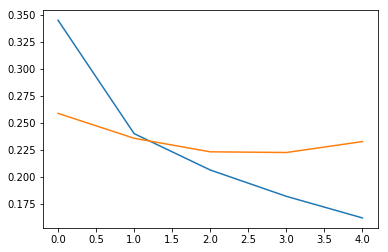

In [8]:
plt.plot(train_losses)
plt.plot(val_losses)
# plt.plot(val_accuracy)

In [11]:
logits_list = np.zeros((1,5))
labels_list = np.zeros((1,5))
model.eval()
for batch in (trainloader):
    batch[0]= batch[0].to(device)
    logits = model(batch[0]).to("cpu").detach().numpy() > 0.5
    labels = batch[1].to("cpu").numpy()
    
    logits_list = np.concatenate((logits_list,logits),0)
    labels_list = np.concatenate((labels_list,labels),0)
    
    torch.cuda.empty_cache()
for i in range(logits_list.shape[0]):
    for j in range(logits_list.shape[1]):
        if(logits_list[i][2]==1 and j!=2):
            logits_list[i][j]=0
print(precision_score(labels_list[1:], logits_list[1:], average='weighted'))
print(recall_score(labels_list[1:], logits_list[1:], average='weighted'))
print(f1_score(labels_list[1:], logits_list[1:], average='weighted'))

0.885505572823021
0.78099173553719
0.8131256281933344


In [12]:
logits_list = np.zeros((1,5))
labels_list = np.zeros((1,5))
model.eval()
for batch in tqdm(valloader):
    batch[0]= batch[0].to(device)
    logits = model(batch[0]).to("cpu").detach().numpy() > 0.5
    labels = batch[1].to("cpu").numpy()
    
    logits_list = np.concatenate((logits_list,logits),0)
    labels_list = np.concatenate((labels_list,labels),0)
    
    torch.cuda.empty_cache()
print(precision_score(labels_list[1:], logits_list[1:], average='weighted'))
print(recall_score(labels_list[1:], logits_list[1:], average='weighted'))
print(f1_score(labels_list[1:], logits_list[1:], average='weighted'))


0.775889976511213
0.7028248587570621
0.724537692150183


In [13]:
def print_conf(y_true,y_pred,i):
    y_true = labels_list[:,i]
    y_pred = logits_list[:,i]
    matrix_hate = np.zeros((2,2))
    for i in range(len(y_true)):
        true = int(y_true[i])
        pred = int(y_pred[i])
        matrix_hate[true][pred]+=1
    print(matrix_hate)
##coordinate 0 hate
for i in range(5):
    y_true = labels_list[:,i]
    y_pred = logits_list[:,i]
    print_conf(y_true,y_pred,i)

[[659.  43.]
 [ 68.  42.]]
[[694.  15.]
 [ 77.  26.]]
[[363.  14.]
 [ 23. 412.]]
[[715.  20.]
 [ 64.  13.]]
[[603.  49.]
 [ 31. 129.]]


In [24]:
## final_inference on test data

class test_dataset(torch.utils.data.Dataset):
    def __init__(self, datapath):
        
        self.df = pd.read_csv(datapath)
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        sentence = self.df.iloc[idx]["Post"]
        encoding = tokenizer.encode_plus(sentence,add_special_tokens=True,max_length=64,truncation=True,pad_to_max_length=True,return_attention_mask=True)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        uid = int(self.df.iloc[idx]["Unique ID"])

        return np.array(input_ids), np.array(attention_mask), uid
testset = test_dataset("../data/test.csv")
testloader = torch.utils.data.DataLoader(testset, batch_size = 1)
model.eval()
final_result = list()
for batch in tqdm(testloader):
    labels = list()
    x = model(batch[0]).to("cpu").detach().numpy()[0]
    if(x[0]>0.5):
        labels.append("hate")
    if(x[1]>0.5):
        labels.append("offensive")
    if(x[2]>0.5):
        labels.append("non-hostile")
    if(x[3]>0.5):
        labels.append("defamation")
    if(x[4]>0.5):
        labels.append("fake")
    if(labels==[]):
        labels = taglist[np.argmin(np.array(x))]
    final_result.append((batch[2].item(),labels))

In [25]:
final_result

[(1, ['hate']),
 (2, ['non-hostile']),
 (3, 'non-hostile'),
 (4, ['fake']),
 (5, 'non-hostile'),
 (6, ['non-hostile']),
 (7, ['non-hostile']),
 (8, ['hate']),
 (9, ['fake']),
 (10, 'non-hostile'),
 (11, ['fake']),
 (12, 'non-hostile'),
 (13, ['non-hostile']),
 (14, ['hate']),
 (15, ['offensive']),
 (16, ['fake']),
 (17, 'fake'),
 (18, ['non-hostile']),
 (19, ['hate']),
 (20, ['hate', 'offensive']),
 (21, ['non-hostile']),
 (22, ['fake']),
 (23, ['non-hostile']),
 (24, ['fake']),
 (25, ['non-hostile']),
 (26, ['hate']),
 (27, 'non-hostile'),
 (28, ['offensive']),
 (29, 'non-hostile'),
 (30, ['non-hostile']),
 (31, ['non-hostile']),
 (32, ['non-hostile']),
 (33, ['fake']),
 (34, ['fake']),
 (35, ['non-hostile']),
 (36, ['non-hostile']),
 (37, ['non-hostile']),
 (38, ['non-hostile']),
 (39, ['hate']),
 (40, ['non-hostile']),
 (41, 'offensive'),
 (42, ['non-hostile']),
 (43, ['non-hostile']),
 (44, 'fake'),
 (45, ['fake']),
 (46, ['offensive']),
 (47, ['non-hostile']),
 (48, ['fake']),
 (4

In [22]:
np.array(final_result[0][1])

array([0.5358125 , 0.20281869, 0.01395807, 0.38834518, 0.03609497],
      dtype=float32)